In [3]:
print('学习率衰减')



学习率衰减


In [4]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import CIFAR10
from C5_CNN.utils import resnet
from torchvision import transforms as tfs
from datetime import datetime




In [5]:
net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)


In [6]:
# 访问参数组
print('learning rate: {}'.format(optimizer.param_groups[0]['lr']))
print('weight decay: {}'.format(optimizer.param_groups[0]['weight_decay']))



learning rate: 0.01
weight decay: 0.0001


In [7]:
# 用循环来修改学习率
def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




In [8]:
#  使用数据增强
def train_tf(x):
    img_aug = tfs.Compose([
        tfs.Resize(120),
        tfs.RandomHorizontalFlip(),
        tfs.RandomCrop(96),
        tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = img_aug(x)
    return x

def test_tf(x):
    im_aug =tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

train_set = CIFAR10('../data', train=True, transform=train_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)
valid_set = CIFAR10('../data', train=False, transform=test_tf)
valid_data = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=False, num_workers=4)

net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()




In [11]:
# 使用学习率下降的训练过程
train_losses = []
valid_losses = []
if torch.cuda.is_available():
    net = net.cuda()
prev_time = datetime.now()
for epoch in range(30):
    if epoch == 20:
        set_learning_rate(optimizer, 0.01)
    train_loss = 0
    net = net.train()
    for im, label in train_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda()) # (bs, 3, h, w)
            label = Variable(label.cuda()) #(bs, h, w)
        else:
            im = Variable(im)
            label = Variable(label)
        # forward
        output = net(im)
        loss = criterion(output, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = 'Time %02d:%02d:%02d'%(h, m, s)
    # Valid 
    valid_loss = 0
    valid_acc = 0
    net = net.eval()
    for im, label in valid_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda(), volatile=True)
            label = Variable(label.cuda(), volatile=True)
        else:
            im = Variable(im, volatile=True)
            label = Variable(label, volatile=True)
        output = net(im)
        loss = criterion(output, label)
        valid_loss += loss.item()
    epoch_str = ("Epoch %d. Train Loss: %f, Valid Loss: %f, " 
        % (epoch, train_loss / len(train_data), valid_loss / len(valid_data)))
    prev_time = cur_time
    
    train_losses.append(train_loss / len(train_data))
    valid_losses.append(valid_loss / len(valid_data))
    print(epoch_str + time_str)

/home/rong/PycharmProjects/PyTorchTutorals/venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rong/PycharmProjects/PyTorchTutorals/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 0. Train Loss: 1.042895, Valid Loss: 1.034408, Time 00:05:26
Epoch 1. Train Loss: 0.918543, Valid Loss: 1.040510, Time 00:06:16
Epoch 2. Train Loss: 0.845206, Valid Loss: 0.830556, Time 00:06:16
Epoch 3. Train Loss: 0.787496, Valid Loss: 0.937584, Time 00:06:16
Epoch 4. Train Loss: 0.736519, Valid Loss: 0.705696, Time 00:06:16
Epoch 5. Train Loss: 0.692898, Valid Loss: 0.705906, Time 00:06:16
Epoch 6. Train Loss: 0.667626, Valid Loss: 0.691745, Time 00:06:16
Epoch 7. Train Loss: 0.639939, Valid Loss: 0.657443, Time 00:06:16
Epoch 8. Train Loss: 0.609430, Valid Loss: 0.651851, Time 00:06:16
Epoch 9. Train Loss: 0.588477, Valid Loss: 0.696674, Time 00:06:16
Epoch 10. Train Loss: 0.569357, Valid Loss: 0.608400, Time 00:06:16
Epoch 11. Train Loss: 0.547294, Valid Loss: 0.618299, Time 00:06:16
Epoch 12. Train Loss: 0.534495, Valid Loss: 0.718645, Time 00:06:16
Epoch 13. Train Loss: 0.515784, Valid Loss: 0.616882, Time 00:06:16
Epoch 14. Train Loss: 0.503121, Valid Loss: 0.579025, Time

/home/rong/PycharmProjects/PyTorchTutorals/venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rong/PycharmProjects/PyTorchTutorals/venv/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 0. Train Loss: 0.214309, Valid Loss: 0.409717, Time 00:05:24
Epoch 1. Train Loss: 0.211966, Valid Loss: 0.404687, Time 00:06:18
Epoch 2. Train Loss: 0.204345, Valid Loss: 0.405009, Time 00:06:17
Epoch 3. Train Loss: 0.196487, Valid Loss: 0.399183, Time 00:06:17
Epoch 4. Train Loss: 0.196535, Valid Loss: 0.418046, Time 00:06:16
Epoch 5. Train Loss: 0.189401, Valid Loss: 0.395768, Time 00:06:22
Epoch 6. Train Loss: 0.184644, Valid Loss: 0.394142, Time 00:06:24
Epoch 7. Train Loss: 0.179963, Valid Loss: 0.397928, Time 00:06:24
Epoch 8. Train Loss: 0.175424, Valid Loss: 0.408250, Time 00:06:39
Epoch 9. Train Loss: 0.171820, Valid Loss: 0.398202, Time 00:06:22
Epoch 10. Train Loss: 0.168875, Valid Loss: 0.402376, Time 00:06:18
Epoch 11. Train Loss: 0.163697, Valid Loss: 0.388751, Time 00:06:18
Epoch 12. Train Loss: 0.161776, Valid Loss: 0.391308, Time 00:06:18
Epoch 13. Train Loss: 0.159828, Valid Loss: 0.402509, Time 00:06:14
Epoch 14. Train Loss: 0.153621, Valid Loss: 0.421869, Time

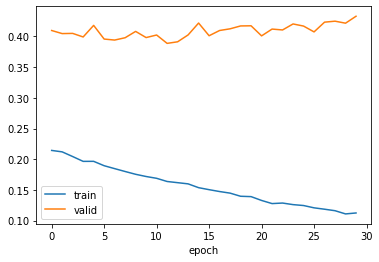

In [13]:
# 使用学习率恒定的训练过程
train_losses = []
valid_losses = []
if torch.cuda.is_available():
    net = net.cuda()
prev_time = datetime.now()
for epoch in range(30):
    train_loss = 0
    net = net.train()
    for im, label in train_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda()) # (bs, 3, h, w)
            label = Variable(label.cuda()) #(bs, h, w)
        else:
            im = Variable(im)
            label = Variable(label)
        # forward
        output = net(im)
        loss = criterion(output, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = 'Time %02d:%02d:%02d'%(h, m, s)
    # Valid 
    valid_loss = 0
    valid_acc = 0
    net = net.eval()
    for im, label in valid_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda(), volatile=True)
            label = Variable(label.cuda(), volatile=True)
        else:
            im = Variable(im, volatile=True)
            label = Variable(label, volatile=True)
        output = net(im)
        loss = criterion(output, label)
        valid_loss += loss.item()
    epoch_str = ("Epoch %d. Train Loss: %f, Valid Loss: %f, " 
        % (epoch, train_loss / len(train_data), valid_loss / len(valid_data)))
    prev_time = cur_time
    
    train_losses.append(train_loss / len(train_data))
    valid_losses.append(valid_loss / len(valid_data))
    print(epoch_str + time_str)

# 画出Loss曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')
# 画出Loss曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')




/home/rong/PycharmProjects/PyTorchTutorals/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/rong/PycharmProjects/PyTorchTutorals/venv/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 0. Train Loss: 0.110595, Valid Loss: 0.439456, Time 00:05:31
Epoch 1. Train Loss: 0.110258, Valid Loss: 0.430864, Time 00:06:25
Epoch 2. Train Loss: 0.105953, Valid Loss: 0.410450, Time 00:06:23
Epoch 3. Train Loss: 0.108151, Valid Loss: 0.419615, Time 00:06:27
Epoch 4. Train Loss: 0.099423, Valid Loss: 0.439936, Time 00:06:21
Epoch 5. Train Loss: 0.100512, Valid Loss: 0.436098, Time 00:06:17
Epoch 6. Train Loss: 0.097347, Valid Loss: 0.442634, Time 00:06:16
Epoch 7. Train Loss: 0.097028, Valid Loss: 0.434561, Time 00:06:16
Epoch 8. Train Loss: 0.093876, Valid Loss: 0.441278, Time 00:06:17
Epoch 9. Train Loss: 0.093036, Valid Loss: 0.446929, Time 00:06:16
Epoch 10. Train Loss: 0.089393, Valid Loss: 0.444263, Time 00:06:16
Epoch 11. Train Loss: 0.088375, Valid Loss: 0.437310, Time 00:06:16
Epoch 12. Train Loss: 0.087819, Valid Loss: 0.441402, Time 00:06:16
Epoch 13. Train Loss: 0.087922, Valid Loss: 0.443556, Time 00:06:16
Epoch 14. Train Loss: 0.083129, Valid Loss: 0.441957, Time

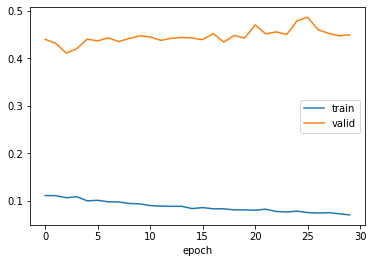

In [14]:
# 使用学习率恒定的训练过程
train_losses = []
valid_losses = []
if torch.cuda.is_available():
    net = net.cuda()
prev_time = datetime.now()
for epoch in range(30):
    if epoch == 20:
        set_learning_rate(optimizer, 0.01)
    train_loss = 0
    net = net.train()
    for im, label in train_data:
        if torch.cuda.is_available():
            im = Variable(im.cuda()) # (bs, 3, h, w)
            label = Variable(label.cuda()) #(bs, h, w)
        else:
            im = Variable(im)
            label = Variable(label)
        # forward
        output = net(im)
        loss = criterion(output, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = 'Time %02d:%02d:%02d'%(h, m, s)
    # Valid 
    valid_loss = 0
    valid_acc = 0
    net = net.eval()
    for im, label in valid_data:
        with torch.no_grad():
            if torch.cuda.is_available():
                im = Variable(im.cuda(), volatile=True)
                label = Variable(label.cuda(), volatile=True)
            else:
                im = Variable(im, volatile=True)
                label = Variable(label, volatile=True)
        output = net(im)
        loss = criterion(output, label)
        valid_loss += loss.item()
    epoch_str = ("Epoch %d. Train Loss: %f, Valid Loss: %f, " 
        % (epoch, train_loss / len(train_data), valid_loss / len(valid_data)))
    prev_time = cur_time
    
    train_losses.append(train_loss / len(train_data))
    valid_losses.append(valid_loss / len(valid_data))
    print(epoch_str + time_str)

# 画出Loss曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')
# 画出Loss曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epoch')
plt.legend(loc='best')



